### Example for using function load_data and printing dataset 

In [1]:
from hw3_utils import load_data
#downsample the training and validation dataset if needed, ds_rate should be larger than 1.
ds_rate=None
datasets = load_data(ds_rate=ds_rate,theano_shared=False)
train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]
print('Current training data size is %i'%train_set_x.shape[0])
print('Current validation data size is %i'%valid_set_x.shape[0])
print('Current test data size is %i'%test_set_x.shape[0])

Current training data size is 40000
Current validation data size is 10000
Current test data size is 10000


Using gpu device 0: GRID K520 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN Version is too old. Update to v5, was 3007.)


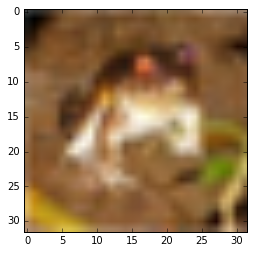

In [3]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(train_set_x[0].reshape(3,32,32).transpose(1,2,0))

In [38]:
def zca_whiten(X):
    """
    Applies ZCA whitening to the data (X)
    http://xcorr.net/2011/05/27/whiten-a-matrix-matlab-code/

    X: numpy 2d array
        input data, rows are data points, columns are features

    Returns: ZCA whitened 2d array
    """
    assert(X.ndim == 2)
    EPS = 10e-5
    #   covariance matrix
    cov = numpy.dot(X.T, X)
    #print('conv:', cov)
    #   d = (lambda1, lambda2, ..., lambdaN)
    d, E = numpy.linalg.eig(cov)
    #print('lambda: ', d)
    #print('eigen matrix nan', numpy.sum(numpy.isnan(E)))
    #   D = diag(d) ^ (-1/2)
    D = numpy.diag(1. / numpy.sqrt(d + EPS))
    #print("D", numpy.sum(numpy.isnan(numpy.diag(D))))
    #   W_zca = E * D * E.T
    #print("dot(E,D) nan ", numpy.sum(numpy.isnan(numpy.dot(E,D))))
    W = numpy.dot(numpy.dot(E, D), E.T)
    #print('W', W)
    X_white = numpy.dot(X, W)
    return X_white

def global_contrast_normalize(X, scale=1., subtract_mean=True, use_std=False, sqrt_bias=0.1, min_divisor=1e-8):
    """
    Global contrast normalizes by (optionally) subtracting the mean
    across features and then normalizes by either the vector norm
    or the standard deviation (across features, for each example).
    Parameters
    ----------
    X : ndarray, 2-dimensional
        Design matrix with examples indexed on the first axis and \
        features indexed on the second.
    scale : float, optional
        Multiply features by this const.
    subtract_mean : bool, optional
        Remove the mean across features/pixels before normalizing. \
        Defaults to `True`.
    use_std : bool, optional
        Normalize by the per-example standard deviation across features \
        instead of the vector norm. Defaults to `False`.
    sqrt_bias : float, optional
        Fudge factor added inside the square root. Defaults to 0.
    min_divisor : float, optional
        If the divisor for an example is less than this value, \
        do not apply it. Defaults to `1e-8`.
    Returns
    -------
    Xp : ndarray, 2-dimensional
        The contrast-normalized features.
    Notes
    -----
    `sqrt_bias` = 10 and `use_std = True` (and defaults for all other
    parameters) corresponds to the preprocessing used in [1].
    References
    ----------
    .. [1] A. Coates, H. Lee and A. Ng. "An Analysis of Single-Layer
       Networks in Unsupervised Feature Learning". AISTATS 14, 2011.
       http://www.stanford.edu/~acoates/papers/coatesleeng_aistats_2011.pdf
    """
    assert X.ndim == 2, "X.ndim must be 2"
    scale = float(scale)
    assert scale >= min_divisor

    # Note: this is per-example mean across pixels, not the
    # per-pixel mean across examples. So it is perfectly fine
    # to subtract this without worrying about whether the current
    # object is the train, valid, or test set.
    mean = X.mean(axis=1)
    if subtract_mean:
        X = X - mean[:, numpy.newaxis]  # Makes a copy.
    else:
        X = X.copy()

    if use_std:
        # ddof=1 simulates MATLAB's var() behaviour, which is what Adam
        # Coates' code does.
        ddof = 1

        # If we don't do this, X.var will return nan.
        if X.shape[1] == 1:
            ddof = 0

        normalizers = numpy.sqrt(sqrt_bias + X.var(axis=1, ddof=ddof)) / scale
    else:
        normalizers = numpy.sqrt(sqrt_bias + (X ** 2).sum(axis=1)) / scale

    # Don't normalize by anything too small.
    normalizers[normalizers < min_divisor] = 1.

    X /= normalizers[:, numpy.newaxis]  # Does not make a copy.
    return X

In [40]:
import numpy
import theano
datasets = load_data()
train_set_x, train_set_y = datasets[0]
n_train_batches = train_set_x.get_value(borrow=True).shape[0]
train_x_tmp = train_set_x.get_value()
train_x = train_x_tmp.reshape(n_train_batches, 3, 32*32)
train_x_norm_white = numpy.empty_like(train_x, dtype = train_x.dtype)
train_tmp = numpy.empty_like(train_set_x, dtype = train_set_x.dtype)
for i in range(0,3):
    train_x_norm_white[:,i,:] = zca_whiten(global_contrast_normalize(train_x[:,i,:], scale=1., subtract_mean=True, \
                                                                    use_std=False, sqrt_bias=0., min_divisor=1e-8))
    #print("num of nan:", numpy.sum(numpy.isnan(train_x_norm_white[:,i,:])))
    #print("array: ", train_x_norm_white[:,i,:])
train_set_x.set_value(train_x_norm_white.reshape(n_train_batches, 32*32*3))
print("num of nan:", numpy.sum(numpy.isnan(train_set_x.get_value())))

#train_x_norm_white[:,i,:] = zca_whiten()

('num of nan:', 0)


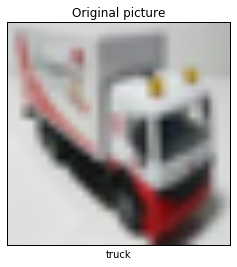

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
class_=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
#Choose an image index
i=15
plt.imshow(np.reshape(valid_set_x[i],(3,32,32)).transpose(1,2,0))
plt.xticks([])
plt.yticks([])
plt.title('Original picture')
plt.xlabel('%s'%class_[valid_set_y[i]])

# ECBM E6040 Homework 3 - Programming Problem

### Problem 1: Implement the convolutional neural network depicted in this problem

In [1]:
from hw3 import test_lenet
test_lenet()

... building the model
training @ iter =  0
epoch 1, minibatch 80/80, validation error 71.430000 %
     epoch 1, minibatch 80/80, test error of best model 70.800000 %
training @ iter =  100
epoch 2, minibatch 80/80, validation error 62.150000 %
     epoch 2, minibatch 80/80, test error of best model 61.660000 %
training @ iter =  200
epoch 3, minibatch 80/80, validation error 59.930000 %
     epoch 3, minibatch 80/80, test error of best model 59.910000 %
training @ iter =  300
epoch 4, minibatch 80/80, validation error 51.650000 %
     epoch 4, minibatch 80/80, test error of best model 51.650000 %
epoch 5, minibatch 80/80, validation error 49.710000 %
     epoch 5, minibatch 80/80, test error of best model 49.090000 %
training @ iter =  400
epoch 6, minibatch 80/80, validation error 46.100000 %
     epoch 6, minibatch 80/80, test error of best model 45.750000 %
training @ iter =  500
epoch 7, minibatch 80/80, validation error 46.140000 %
training @ iter =  600
epoch 8, minibatch 80/80,

Using gpu device 0: GRID K520 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN Version is too old. Update to v5, was 3007.)
The training process for function test_lenet ran for 47.07m


Best validation error of 32.220000 % obtained at iteration 9920, with test performance 32.530000 %


### Problem 2: Bullet 1: Augmentation by translation

Show a 4*4 figure of 16 input images with this augmentation

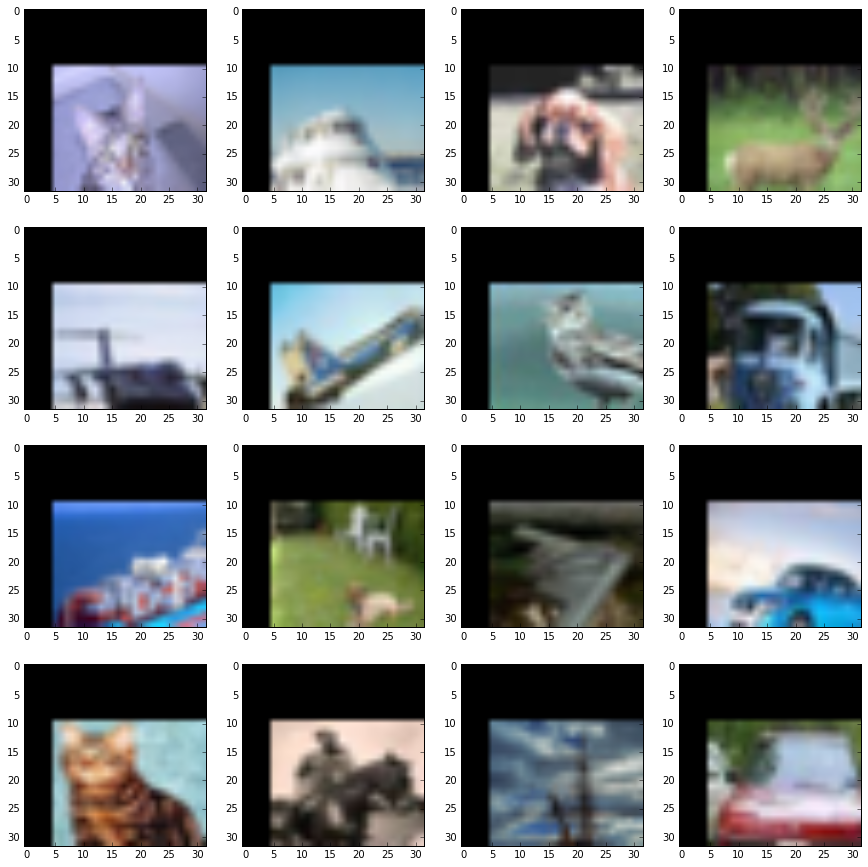

In [17]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from hw3_utils import load_data
from hw3 import translate_image

imgs16, labels16 = translate_image(train_set_x, train_set_y, 5, 10, 16, 0)
plt.figure(figsize = (15,15))
for i in range(0, 4):
    for j in range(1,5):
        plt.subplot(4,4, i*4+j)
        plt.imshow(imgs16[i*4+j - 1].reshape(3,32,32).transpose(1,2,0))

Implement the neural network with this augmentation, show the improvement

In [2]:
from hw3 import test_lenet_translation
test_lenet_translation(learning_rate=0.1, n_epochs=200, num_samples = 40000, nkerns=[32, 64], batch_size=500)

... building the model
function name: translate_image
we use translate_image
Total 80 iteration
--------Training augmented data-----------
--------Training over-----------
training @ iter =  0
epoch 1, minibatch 80/80, validation error 59.920000 %
     epoch 1, minibatch 80/80, test error of best model 59.440000 %
Total 80 iteration
--------Training augmented data-----------
--------Training over-----------
training @ iter =  100
epoch 2, minibatch 80/80, validation error 50.530000 %
     epoch 2, minibatch 80/80, test error of best model 50.600000 %
Total 80 iteration
--------Training augmented data-----------
--------Training over-----------
training @ iter =  200
epoch 3, minibatch 80/80, validation error 45.990000 %
     epoch 3, minibatch 80/80, test error of best model 46.060000 %
Total 80 iteration
--------Training augmented data-----------
--------Training over-----------
training @ iter =  300
epoch 4, minibatch 80/80, validation error 44.250000 %
     epoch 4, minibatch 80/80

The training process for function test_lenet_translation ran for 96.85m


### Problem 2: Bullet 2: Augmentation by rotation

Show a 4*4 figure of 16 input images with this augmentation

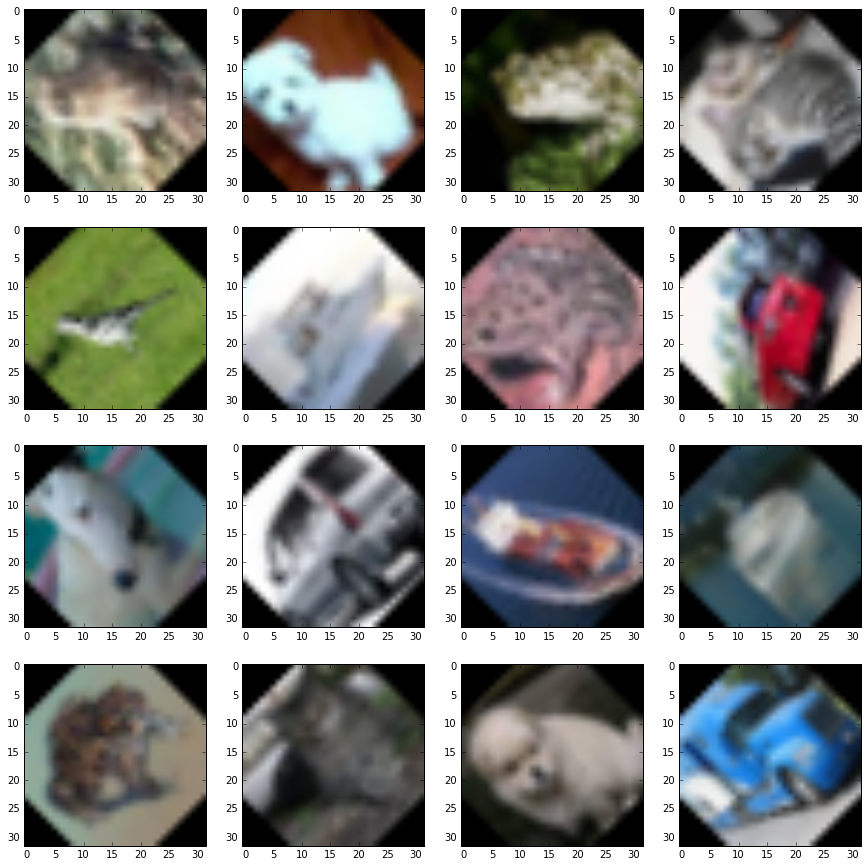

In [18]:
from hw3_utils import load_data
from hw3 import rotate_image
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from hw3_utils import load_data
from hw3 import translate_image

imgs16, labels16 = rotate_image(train_set_x, train_set_y, 16, 32, 32, 45, 1)
plt.figure(figsize = (15,15))
for i in range(0, 4):
    for j in range(1,5):
        plt.subplot(4,4, i*4+j)
        plt.imshow(imgs16[i*4+j - 1].reshape(3,32,32).transpose(1,2,0))

Implement the neural network with this augmentation, show the improvement

In [ ]:
from hw3 import test_lenet_rotation
test_lenet_rotation(learning_rate=0.1, n_epochs=200, num_samples = 40000, nkerns=[32, 64], batch_size=500)

... building the model
function name: rotate_image
we use rotate_image
Total 80 iteration
--------Training augmented data-----------
--------Training over-----------
training @ iter =  0
epoch 1, minibatch 80/80, validation error 59.120000 %
     epoch 1, minibatch 80/80, test error of best model 58.290000 %
Total 80 iteration
--------Training augmented data-----------
--------Training over-----------
training @ iter =  100
epoch 2, minibatch 80/80, validation error 52.190000 %
     epoch 2, minibatch 80/80, test error of best model 52.210000 %
Total 80 iteration
--------Training augmented data-----------
--------Training over-----------
training @ iter =  200
epoch 3, minibatch 80/80, validation error 47.870000 %
     epoch 3, minibatch 80/80, test error of best model 47.630000 %
Total 80 iteration
--------Training augmented data-----------
--------Training over-----------
training @ iter =  300
epoch 4, minibatch 80/80, validation error 44.860000 %
     epoch 4, minibatch 80/80, test

The training process for function test_lenet_rotation ran for 97.51m


### Problem 2: Bullet 3: Augmentation by flipping

Show a 4*4 figure of 16 input images with this augmentation

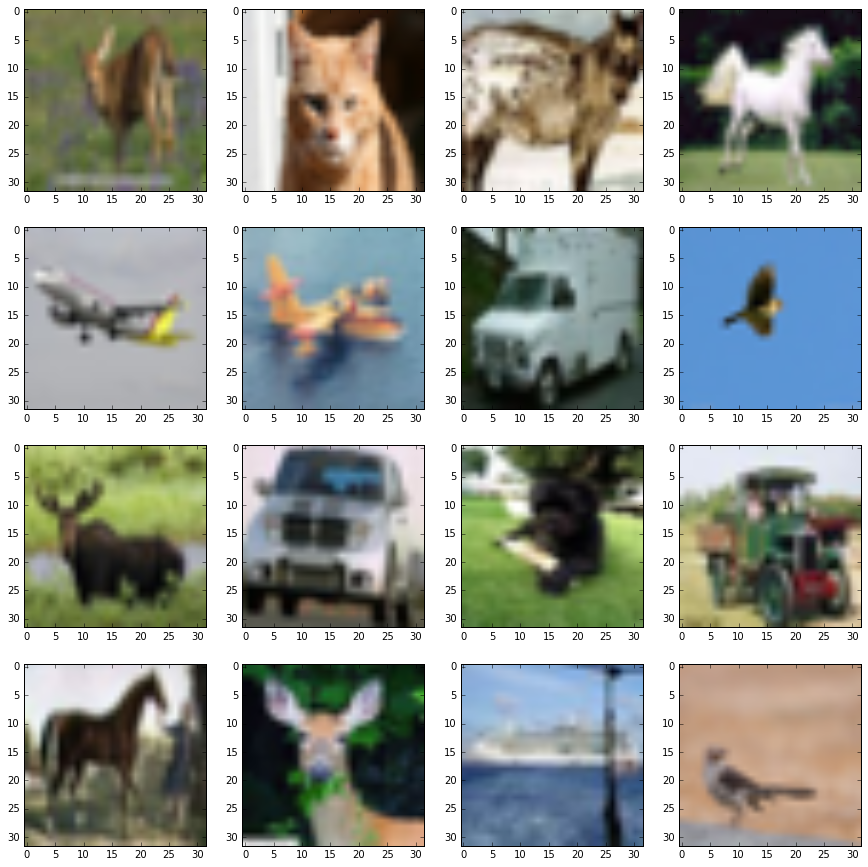

In [19]:
from hw3_utils import load_data
from hw3 import flip_image
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from hw3_utils import load_data
from hw3 import translate_image

imgs16, labels16 = flip_image(train_set_x, train_set_y, 16)
plt.figure(figsize = (15,15))
for i in range(0, 4):
    for j in range(1,5):
        plt.subplot(4,4, i*4+j)
        plt.imshow(imgs16[i*4+j - 1].reshape(3,32,32).transpose(1,2,0))

Implement the neural network with this augmentation, show the improvement

In [ ]:
from hw3 import test_lenet_flip
test_lenet_flip(learning_rate=0.1, n_epochs=200, num_samples = 40000, nkerns=[32, 64], batch_size=500)

... building the model
function name: flip_image
we use flip_image
Total 80 iteration
--------Training augmented data-----------
--------Training over-----------
training @ iter =  0
epoch 1, minibatch 80/80, validation error 70.980000 %
     epoch 1, minibatch 80/80, test error of best model 71.130000 %
Total 80 iteration
--------Training augmented data-----------
--------Training over-----------
training @ iter =  100
epoch 2, minibatch 80/80, validation error 51.400000 %
     epoch 2, minibatch 80/80, test error of best model 51.210000 %
Total 80 iteration
--------Training augmented data-----------
--------Training over-----------
training @ iter =  200
epoch 3, minibatch 80/80, validation error 44.990000 %
     epoch 3, minibatch 80/80, test error of best model 45.250000 %
Total 80 iteration
--------Training augmented data-----------
--------Training over-----------
training @ iter =  300
epoch 4, minibatch 80/80, validation error 44.050000 %
     epoch 4, minibatch 80/80, test err

The training process for function test_lenet_flip ran for 94.41m


### Problem 2: Bullet 4: Augmentation by injecting noise into input

Show a 4*4 figure of 16 input images with this augmentation

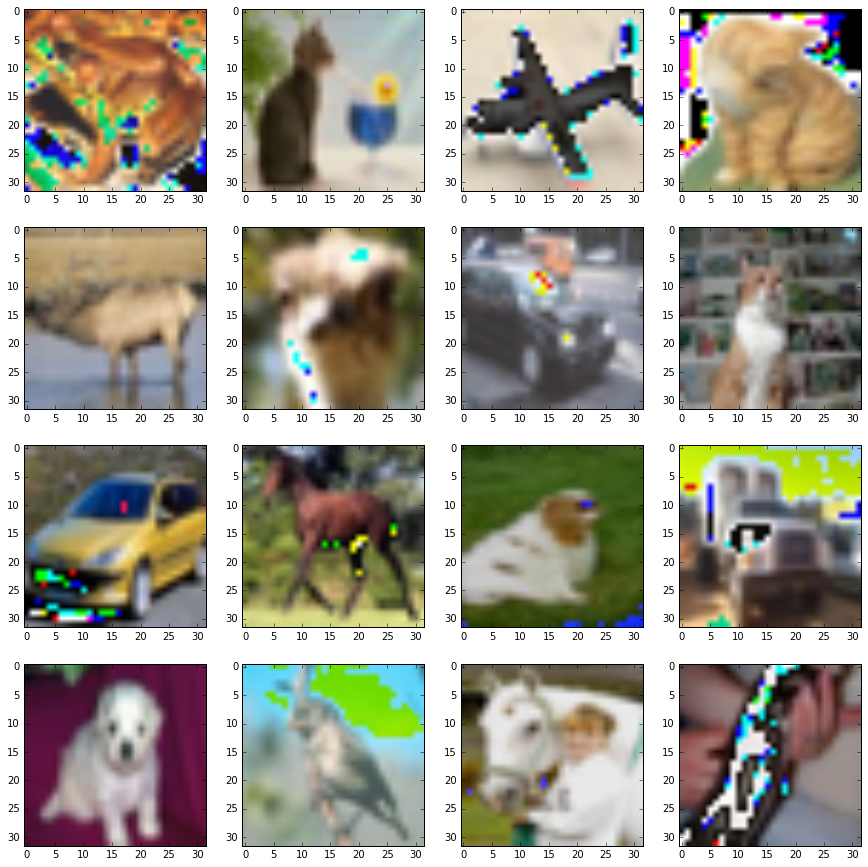

In [4]:
from hw3_utils import load_data
from hw3 import noise_injection 
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from hw3_utils import load_data
from hw3 import translate_image

# Use gauissan(0, 0.1)
imgs16, labels16 = noise_injection(train_set_x, train_set_y, 0, 16)
plt.figure(figsize = (15,15))
for i in range(0, 4):
    for j in range(1,5):
        plt.subplot(4,4, i*4+j)
        plt.imshow(imgs16[i*4+j - 1].reshape(3,32,32).transpose(1,2,0))

Implement the neural network with this augmentation, show the improvement

In [1]:
from hw3 import test_lenet_inject_noise_input
test_lenet_inject_noise_input(learning_rate=0.1, n_epochs=200, num_samples = 40000, nkerns=[32, 64], batch_size=500)

... building the model
function name: noise_injection
we use noise injection and switch between gaussian and uniform
Total 80 iteration
--------Training augmented data-----------
--------Training over-----------
training @ iter =  0
epoch 1, minibatch 80/80, validation error 60.250000 %
     epoch 1, minibatch 80/80, test error of best model 60.010000 %
Total 80 iteration
--------Training augmented data-----------
--------Training over-----------
training @ iter =  100
epoch 2, minibatch 80/80, validation error 51.000000 %
     epoch 2, minibatch 80/80, test error of best model 50.730000 %
Total 80 iteration
--------Training augmented data-----------
--------Training over-----------
training @ iter =  200
epoch 3, minibatch 80/80, validation error 46.270000 %
     epoch 3, minibatch 80/80, test error of best model 46.230000 %
Total 80 iteration
--------Training augmented data-----------
--------Training over-----------
training @ iter =  300
epoch 4, minibatch 80/80, validation error 4

Using gpu device 0: GRID K520 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN Version is too old. Update to v5, was 3007.)
The training process for function test_lenet_inject_noise_input ran for 93.40m


Best validation error of 30.880000 % obtained at iteration 6480, with test performance 32.010000 %


### Problem 3: Implement your own achritecture to achieve at least 80% testing accuracy on CIFAR-10 test set

In [ ]:
from hw3 import MY_lenet
MY_lenet()


... building the model
Start training now
Training flip data...

training @ iter = 0
training @ iter = 100
epoch 1, minibatch 200/200, validation error 50.690000 %
     epoch 1, minibatch 200/200, test error of best model 50.520000 %
training @ iter = 200
training @ iter = 300
epoch 2, minibatch 200/200, validation error 43.240000 %
     epoch 2, minibatch 200/200, test error of best model 43.370000 %
training @ iter = 400
training @ iter = 500
epoch 3, minibatch 200/200, validation error 37.600000 %
     epoch 3, minibatch 200/200, test error of best model 36.940000 %
training @ iter = 600
training @ iter = 700
epoch 4, minibatch 200/200, validation error 32.990000 %
     epoch 4, minibatch 200/200, test error of best model 32.520000 %
training @ iter = 800
training @ iter = 900
epoch 5, minibatch 200/200, validation error 30.630000 %
     epoch 5, minibatch 200/200, test error of best model 30.460000 %
training @ iter = 1000
training @ iter = 1100
epoch 6, minibatch 200/200, validation error 28.940000 %
     epoch 6, minibatch 200/200, test error of best model 29.390000 %
training @ iter = 1200
training @ iter = 1300
epoch 7, minibatch 200/200, validation error 28.180000 %
     epoch 7, minibatch 200/200, test error of best model 28.960000 %
training @ iter = 1400
training @ iter = 1500
epoch 8, minibatch 200/200, validation error 27.260000 %
     epoch 8, minibatch 200/200, test error of best model 28.440000 %
training @ iter = 1600
training @ iter = 1700
epoch 9, minibatch 200/200, validation error 26.370000 %
     epoch 9, minibatch 200/200, test error of best model 27.650000 %
training @ iter = 1800
training @ iter = 1900
epoch 10, minibatch 200/200, validation error 26.180000 %
     epoch 10, minibatch 200/200, test error of best model 27.330000 %
training @ iter = 2000
training @ iter = 2100
epoch 11, minibatch 200/200, validation error 26.410000 %
training @ iter = 2200
training @ iter = 2300
epoch 12, minibatch 200/200, validation error 26.410000 %
training @ iter = 2400
training @ iter = 2500
epoch 13, minibatch 200/200, validation error 25.970000 %
     epoch 13, minibatch 200/200, test error of best model 27.270000 %
training @ iter = 2600
training @ iter = 2700
epoch 14, minibatch 200/200, validation error 25.170000 %
     epoch 14, minibatch 200/200, test error of best model 26.730000 %
training @ iter = 2800
training @ iter = 2900
epoch 15, minibatch 200/200, validation error 24.970000 %
     epoch 15, minibatch 200/200, test error of best model 26.150000 %
training @ iter = 3000
training @ iter = 3100
epoch 16, minibatch 200/200, validation error 25.120000 %
training @ iter = 3200
training @ iter = 3300
epoch 17, minibatch 200/200, validation error 26.750000 %
training @ iter = 3400
training @ iter = 3500
epoch 18, minibatch 200/200, validation error 25.340000 %
training @ iter = 3600
training @ iter = 3700
epoch 19, minibatch 200/200, validation error 24.960000 %
     epoch 19, minibatch 200/200, test error of best model 25.650000 %
training @ iter = 3800
training @ iter = 3900
epoch 20, minibatch 200/200, validation error 24.800000 %
     epoch 20, minibatch 200/200, test error of best model 25.800000 %
training @ iter = 4000
training @ iter = 4100
epoch 21, minibatch 200/200, validation error 24.760000 %
     epoch 21, minibatch 200/200, test error of best model 25.600000 %
training @ iter = 4200
training @ iter = 4300
epoch 22, minibatch 200/200, validation error 24.620000 %
     epoch 22, minibatch 200/200, test error of best model 25.670000 %
training @ iter = 4400
training @ iter = 4500
epoch 23, minibatch 200/200, validation error 24.620000 %
training @ iter = 4600
training @ iter = 4700
epoch 24, minibatch 200/200, validation error 24.560000 %
     epoch 24, minibatch 200/200, test error of best model 25.610000 %
training @ iter = 4800
training @ iter = 4900
epoch 25, minibatch 200/200, validation error 24.580000 %
training @ iter = 5000
training @ iter = 5100
epoch 26, minibatch 200/200, validation error 24.600000 %
training @ iter = 5200
training @ iter = 5300
epoch 27, minibatch 200/200, validation error 24.650000 %
training @ iter = 5400
training @ iter = 5500
epoch 28, minibatch 200/200, validation error 24.650000 %
training @ iter = 5600
training @ iter = 5700
epoch 29, minibatch 200/200, validation error 24.630000 %
training @ iter = 5800
training @ iter = 5900
epoch 30, minibatch 200/200, validation error 24.720000 %
training @ iter = 6000
training @ iter = 6100
epoch 31, minibatch 200/200, validation error 24.740000 %
training @ iter = 6200
training @ iter = 6300
epoch 32, minibatch 200/200, validation error 24.790000 %
training @ iter = 6400
training @ iter = 6500
epoch 33, minibatch 200/200, validation error 24.800000 %
training @ iter = 6600
training @ iter = 6700
epoch 34, minibatch 200/200, validation error 24.800000 %
training @ iter = 6800
training @ iter = 6900
epoch 35, minibatch 200/200, validation error 24.790000 %
training @ iter = 7000
training @ iter = 7100
epoch 36, minibatch 200/200, validation error 24.760000 %
training @ iter = 7200
training @ iter = 7300
epoch 37, minibatch 200/200, validation error 24.730000 %
training @ iter = 7400
training @ iter = 7500
epoch 38, minibatch 200/200, validation error 24.730000 %
training @ iter = 7600
training @ iter = 7700
epoch 39, minibatch 200/200, validation error 24.780000 %
training @ iter = 7800
training @ iter = 7900
epoch 40, minibatch 200/200, validation error 24.780000 %
training @ iter = 8000
training @ iter = 8100
epoch 41, minibatch 200/200, validation error 24.790000 %
training @ iter = 8200
training @ iter = 8300
epoch 42, minibatch 200/200, validation error 24.800000 %
training @ iter = 8400
training @ iter = 8500
epoch 43, minibatch 200/200, validation error 24.790000 %
training @ iter = 8600
training @ iter = 8700
epoch 44, minibatch 200/200, validation error 24.790000 %
training @ iter = 8800
training @ iter = 8900
epoch 45, minibatch 200/200, validation error 24.800000 %
training @ iter = 9000
training @ iter = 9100
epoch 46, minibatch 200/200, validation error 24.800000 %
training @ iter = 9200
training @ iter = 9300
epoch 47, minibatch 200/200, validation error 24.810000 %
training @ iter = 9400
training @ iter = 9500
epoch 48, minibatch 200/200, validation error 24.830000 %
training @ iter = 9600
training @ iter = 9700
epoch 49, minibatch 200/200, validation error 24.820000 %
training @ iter = 9800
training @ iter = 9900
epoch 50, minibatch 200/200, validation error 24.800000 %
training @ iter = 10000
training @ iter = 10100
epoch 51, minibatch 200/200, validation error 24.820000 %
training @ iter = 10200
training @ iter = 10300
epoch 52, minibatch 200/200, validation error 24.840000 %
training @ iter = 10400
training @ iter = 10500
epoch 53, minibatch 200/200, validation error 24.870000 %
training @ iter = 10600
training @ iter = 10700
epoch 54, minibatch 200/200, validation error 24.800000 %
training @ iter = 10800
training @ iter = 10900
epoch 55, minibatch 200/200, validation error 24.800000 %
training @ iter = 11000
training @ iter = 11100
epoch 56, minibatch 200/200, validation error 24.800000 %
training @ iter = 11200
training @ iter = 11300
epoch 57, minibatch 200/200, validation error 24.820000 %
training @ iter = 11400
training @ iter = 11500
epoch 58, minibatch 200/200, validation error 24.820000 %
training @ iter = 11600
training @ iter = 11700
epoch 59, minibatch 200/200, validation error 24.830000 %
training @ iter = 11800
training @ iter = 11900
epoch 60, minibatch 200/200, validation error 24.850000 %
training @ iter = 12000
training @ iter = 12100
epoch 61, minibatch 200/200, validation error 24.830000 %
training @ iter = 12200
training @ iter = 12300
epoch 62, minibatch 200/200, validation error 24.830000 %
training @ iter = 12400
training @ iter = 12500
epoch 63, minibatch 200/200, validation error 24.840000 %
training @ iter = 12600
training @ iter = 12700
epoch 64, minibatch 200/200, validation error 24.850000 %
training @ iter = 12800
training @ iter = 12900
epoch 65, minibatch 200/200, validation error 24.850000 %
training @ iter = 13000
training @ iter = 13100
epoch 66, minibatch 200/200, validation error 24.830000 %
training @ iter = 13200
training @ iter = 13300
epoch 67, minibatch 200/200, validation error 24.870000 %
training @ iter = 13400
training @ iter = 13500
epoch 68, minibatch 200/200, validation error 24.870000 %
training @ iter = 13600
training @ iter = 13700
epoch 69, minibatch 200/200, validation error 24.880000 %
training @ iter = 13800
training @ iter = 13900
epoch 70, minibatch 200/200, validation error 24.870000 %
training @ iter = 14000
training @ iter = 14100
epoch 71, minibatch 200/200, validation error 24.870000 %
training @ iter = 14200
training @ iter = 14300
epoch 72, minibatch 200/200, validation error 24.860000 %
training @ iter = 14400
training @ iter = 14500
epoch 73, minibatch 200/200, validation error 24.870000 %
training @ iter = 14600
training @ iter = 14700
epoch 74, minibatch 200/200, validation error 24.870000 %
training @ iter = 14800
training @ iter = 14900
epoch 75, minibatch 200/200, validation error 24.840000 %
training @ iter = 15000
training @ iter = 15100
epoch 76, minibatch 200/200, validation error 24.840000 %
training @ iter = 15200
training @ iter = 15300
epoch 77, minibatch 200/200, validation error 24.820000 %
training @ iter = 15400
training @ iter = 15500
epoch 78, minibatch 200/200, validation error 24.820000 %
training @ iter = 15600
training @ iter = 15700
epoch 79, minibatch 200/200, validation error 24.820000 %
training @ iter = 15800
training @ iter = 15900
epoch 80, minibatch 200/200, validation error 24.830000 %
training @ iter = 16000
training @ iter = 16100
epoch 81, minibatch 200/200, validation error 24.860000 %
training @ iter = 16200
training @ iter = 16300
epoch 82, minibatch 200/200, validation error 24.850000 %
training @ iter = 16400
training @ iter = 16500
epoch 83, minibatch 200/200, validation error 24.830000 %
training @ iter = 16600
training @ iter = 16700
epoch 84, minibatch 200/200, validation error 24.820000 %
training @ iter = 16800
training @ iter = 16900
epoch 85, minibatch 200/200, validation error 24.800000 %


### Optimal test error: 25.61%

### Problem 4: Implement the convolutional neural network depicted in this problem

... building the model
('patience: ', 4000)
Start training now
('training @ iter = ', 0)
epoch 1, minibatch 200/200, validation error 0.010037
epoch 2, minibatch 200/200, validation error 0.007137
epoch 3, minibatch 200/200, validation error 0.005200
epoch 4, minibatch 200/200, validation error 0.005517
epoch 5, minibatch 200/200, validation error 0.004309
('training @ iter = ', 1000)
epoch 6, minibatch 200/200, validation error 0.003972
epoch 7, minibatch 200/200, validation error 0.003770
epoch 8, minibatch 200/200, validation error 0.003605
epoch 9, minibatch 200/200, validation error 0.003380
epoch 10, minibatch 200/200, validation error 0.003276
('training @ iter = ', 2000)
epoch 11, minibatch 200/200, validation error 0.003173
epoch 12, minibatch 200/200, validation error 0.003033
epoch 13, minibatch 200/200, validation error 0.002970
epoch 14, minibatch 200/200, validation error 0.002921
epoch 15, minibatch 200/200, validation error 0.002820
('training @ iter = ', 3000)
epoch 16

Using gpu device 0: GRID K520 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN Version is too old. Update to v5, was 3007.)


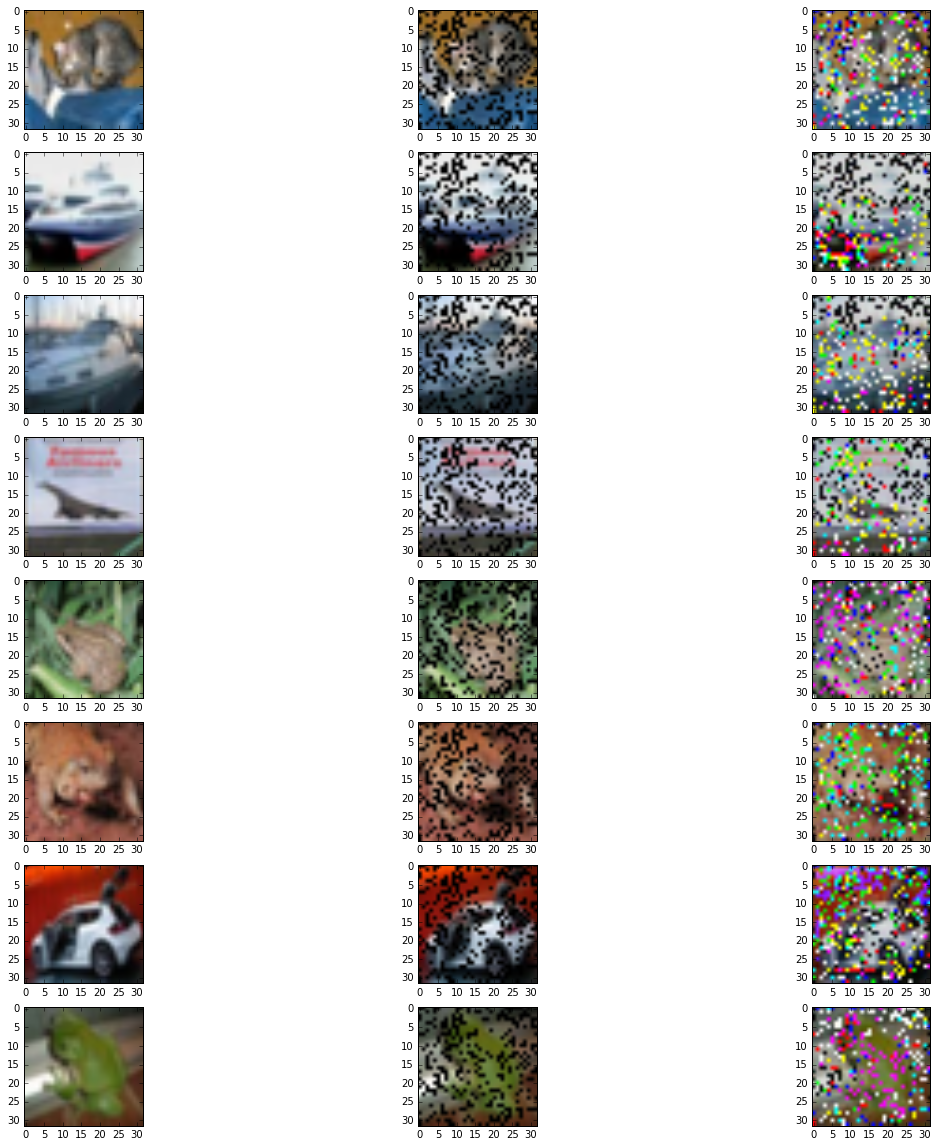

In [1]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from hw3 import MY_CNN
MY_CNN()

... building the model
('patience: ', 20000)
Start training now
('training @ iter = ', 0)
epoch 1, minibatch 200/200, validation error 0.018046
epoch 2, minibatch 200/200, validation error 0.011273
epoch 3, minibatch 200/200, validation error 0.009500
epoch 4, minibatch 200/200, validation error 0.008338
epoch 5, minibatch 200/200, validation error 0.007574
('training @ iter = ', 1000)
epoch 6, minibatch 200/200, validation error 0.007050
epoch 7, minibatch 200/200, validation error 0.006665
epoch 8, minibatch 200/200, validation error 0.006357
epoch 9, minibatch 200/200, validation error 0.006096
epoch 10, minibatch 200/200, validation error 0.005872
('training @ iter = ', 2000)
epoch 11, minibatch 200/200, validation error 0.005678
epoch 12, minibatch 200/200, validation error 0.005506
epoch 13, minibatch 200/200, validation error 0.005353
epoch 14, minibatch 200/200, validation error 0.005215
epoch 15, minibatch 200/200, validation error 0.005091
('training @ iter = ', 3000)
epoch 1

Using gpu device 0: GRID K520 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN Version is too old. Update to v5, was 3007.)


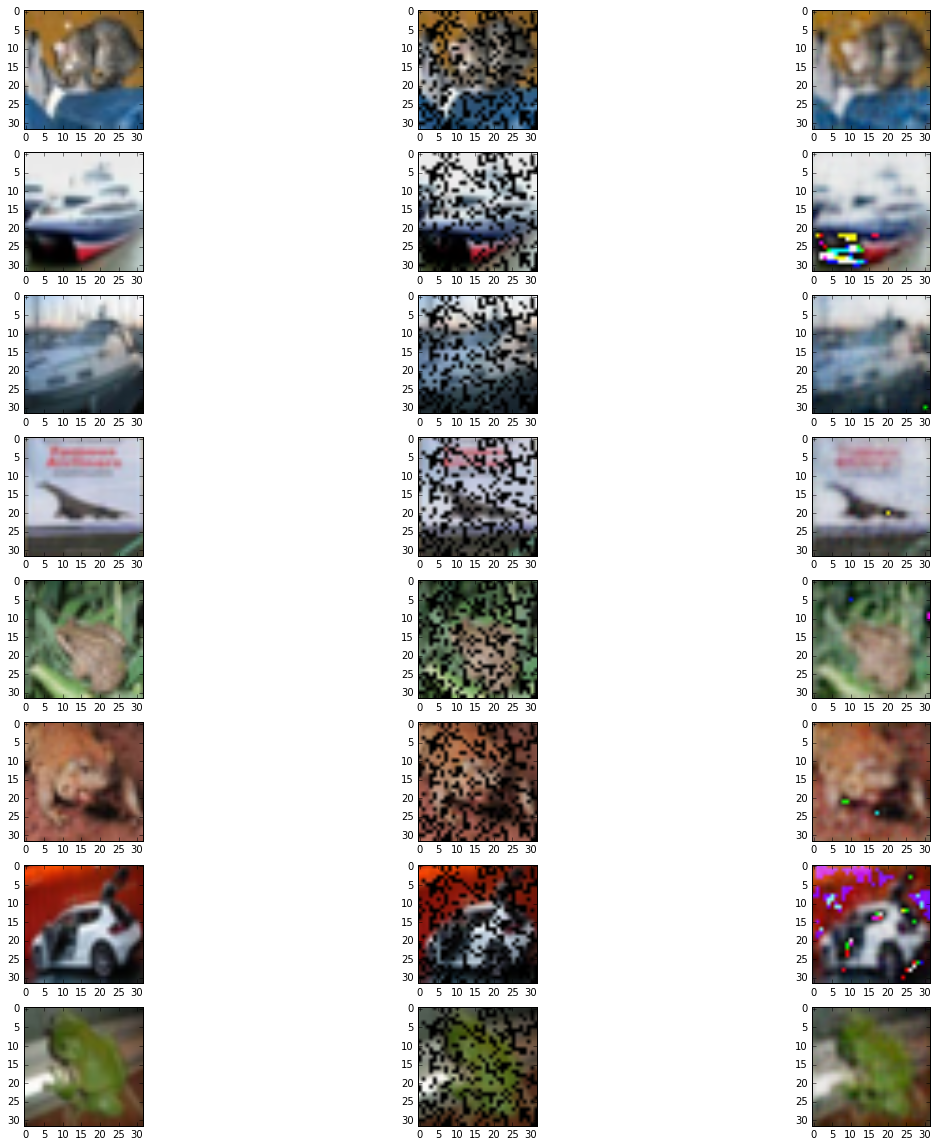

In [1]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from hw3 import MY_CNN
MY_CNN()
